# DETR fine-tuning on the Balloon dataset with COCO pretrained weights

In [4]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.5.0 True


In [5]:
from util.plot_utils import *
from pathlib import Path, PurePath
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import torchvision.transforms as T
import requests
from PIL import Image
torch.set_grad_enabled(False);

In [6]:
import argparse
from models import build_model
import util.via2coco as via2coco

## Prepare the dataset

In [4]:
data_path = 'util/'

for keyword in ['train', 'val']:

  input_dir = data_path + 'Balloon/' + keyword + '2017/'
  input_json = input_dir + 'via_region_data.json'
  categories = ['balloon']
  super_categories = ['N/A']
  output_json = data_path + 'Balloon/annotations/instances_' + keyword + '2017.json'

  print('Converting {} from VIA format to COCO format'.format(input_json))

  coco_dict = via2coco.convert(
      imgdir=input_dir,
      annpath=input_json,
      categories=categories,
      super_categories=super_categories,
      output_file_name=output_json,
      first_class_index=1,
  )

Converting util/Balloon/train2017/via_region_data.json from VIA format to COCO format
Saving to util/Balloon/annotations/instances_train2017.json
Converting util/Balloon/val2017/via_region_data.json from VIA format to COCO format
Saving to util/Balloon/annotations/instances_val2017.json


## Load the pre-trained model and fine-tune it

Remove the classification head to prepare for fine tuning on new dataset.

In [ ]:
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'output\Balloon\detr-pretrained.pth')

In [ ]:
# !python main.py \
#   --coco_path "util\Balloon" \
#   --output_dir "output\Balloon\Pretrained" \
#   --resume "output\Balloon\detr-pretrained.pth" \
#   --num_classes 2 \
#   --epochs 10 \
#   --fine_tune

## Evaluation

-   solid lines are training results,
-   dashed lines are validation results.

In [6]:
!python main.py \
  --coco_path "util\Balloon" \
  --resume "output\Balloon\Pretrained\checkpoint.pth" \
  --batch_size 1 \
  --eval \
  --no_aux_loss \
  --num_classes 2

Not using distributed mode
git:
  sha: eb9f7e03ed8e2ed2cd55528989fe7df890bc3fc0, status: has uncommited changes, branch: master

Namespace(aux_loss=False, backbone='resnet50', batch_size=1, bbox_loss_coef=5, clip_max_norm=0.1, coco_path='util\\Balloon', dataset_file='coco', dec_layers=6, device='cuda', dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=150, eval=True, fine_tune=False, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=100, nheads=8, num_classes=2, num_queries=100, num_workers=2, output_dir='', position_embedding='sine', resume='output\\Balloon\\Pretrained\\checkpoint.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, transfer_learning=False, weight_decay=0.0001, world_size=1)
Building a DETR model with 2 classes
number of params: 41279495
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into m

In [7]:
log_directory = [Path('output\Balloon\Pretrained'), Path('output\Balloon\Fine_tuning_dgx_lr_drop'), Path('output\Balloon\Fine_tuning_tf')]

#### Legend
    BLUE   - pretrained on VOC
    ORANGE - pretrained on COCO

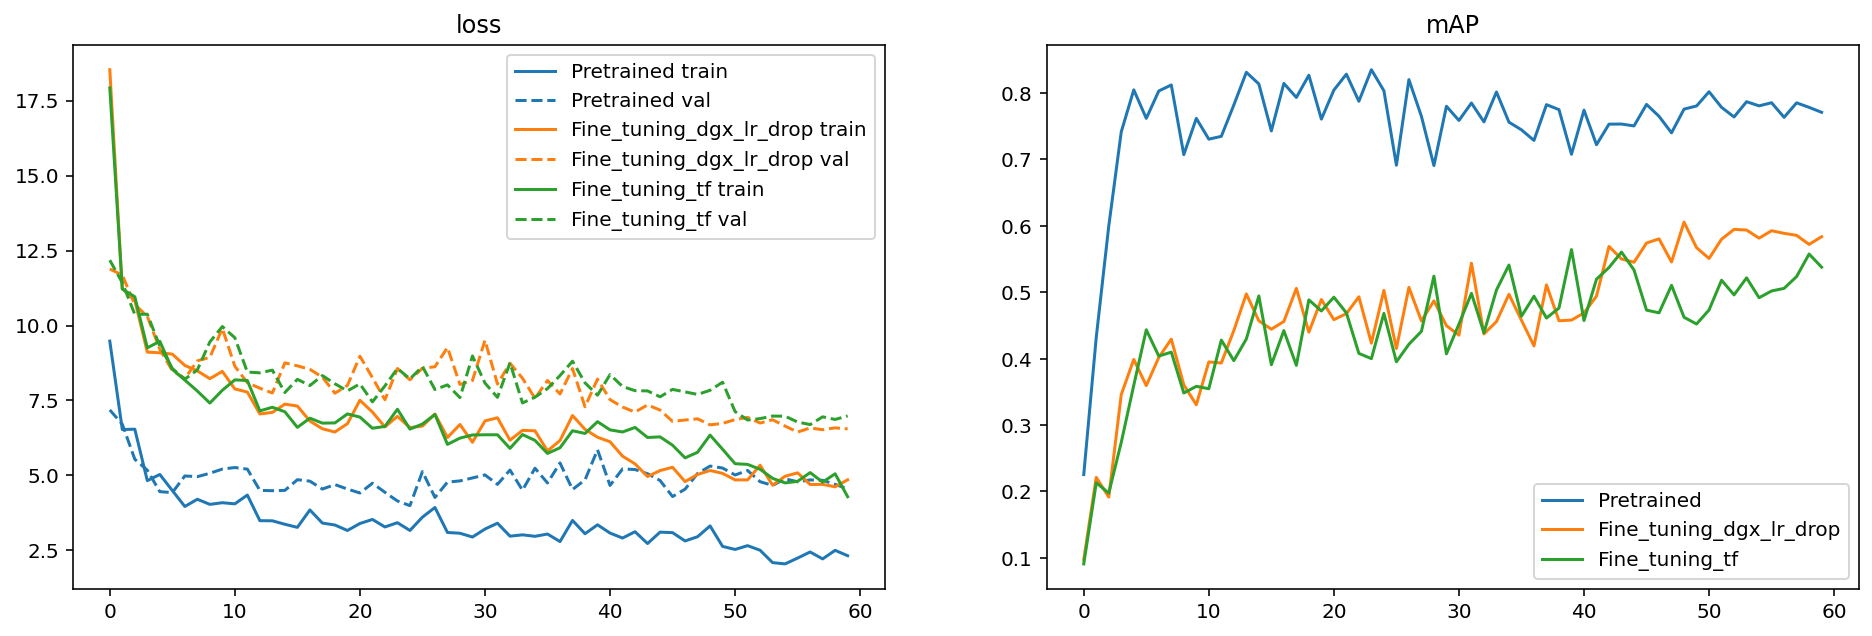

In [8]:
fields_of_interest = ('loss', 'mAP')
plot_logs(log_directory, fields_of_interest)

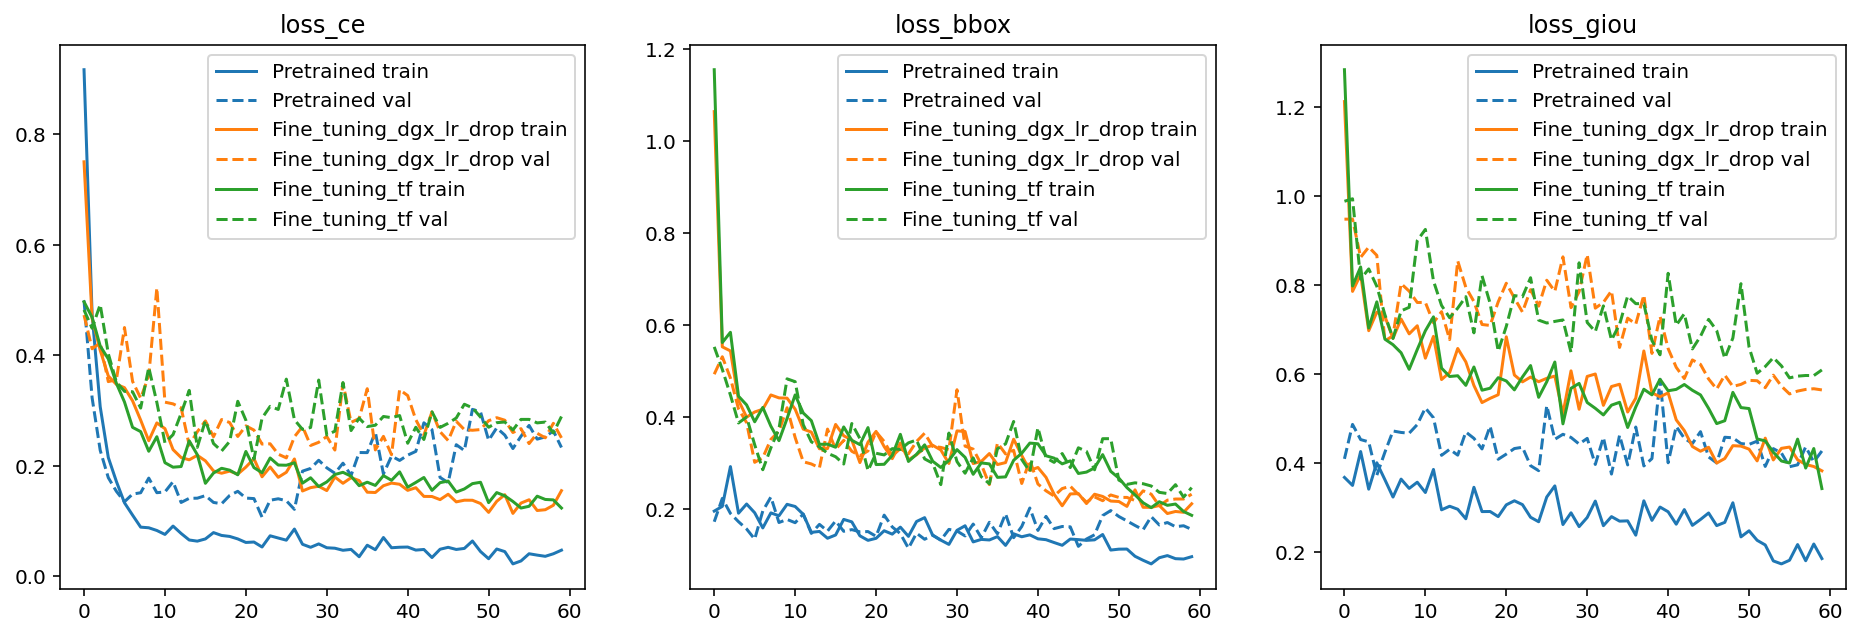

In [9]:
fields_of_interest = ('loss_ce', 'loss_bbox', 'loss_giou')
plot_logs(log_directory, fields_of_interest)

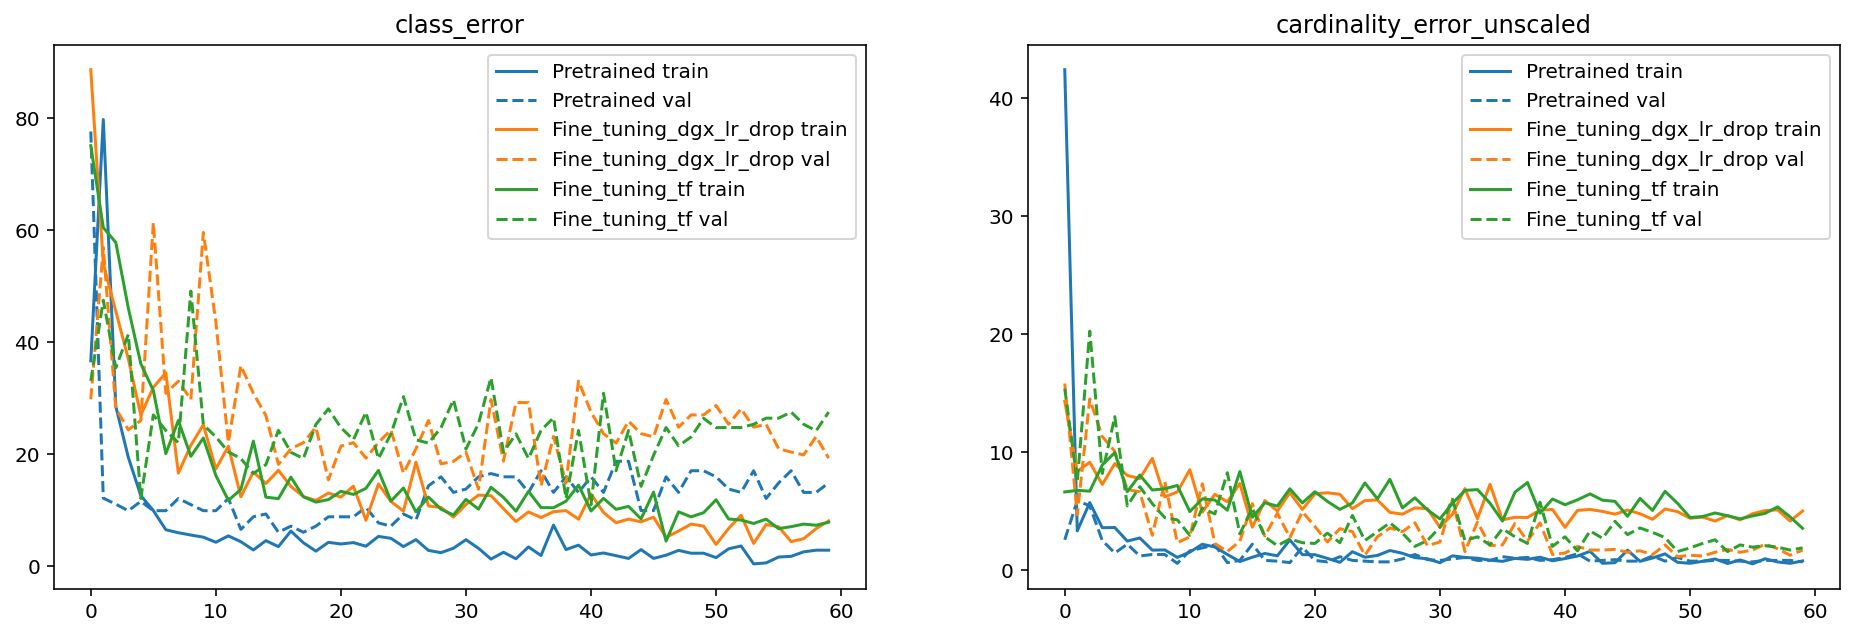

In [10]:
fields_of_interest = ('class_error', 'cardinality_error_unscaled')
plot_logs(log_directory, fields_of_interest) 

## Inference

Define args to instantiate model:

In [11]:
def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--num_classes', type=int, default=None,
                        help="Number of classes in dataset+1")
    
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=100, type=int,
                        help="Number of query slots")
    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset_file', default='coco')
    parser.add_argument('--coco_path', type=str)

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=2, type=int)
    parser.add_argument('--fine_tune', action='store_true')
    
    return parser

In [12]:
parser = argparse.ArgumentParser('DETR evaluation and inference script', parents=[get_args_parser()])
args = parser.parse_args("")

In [13]:
args.aux_loss = False
args.eval = True
args.num_classes = 2
args.resume = 'output\Balloon\Pretrained\checkpoint.pth'

In [14]:
print(args)

Namespace(aux_loss=False, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_path=None, dataset_file='coco', dec_layers=6, device='cuda', dilation=False, dim_feedforward=2048, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=True, fine_tune=False, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, nheads=8, num_classes=2, num_queries=100, num_workers=2, output_dir='', position_embedding='sine', resume='output\\Balloon\\Pretrained\\checkpoint.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001)


### Build model & load weights

In [15]:
model, _, _ = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval();

Building a DETR model with 2 classes


### Utils to display inference results

Define classes and colors to display boxes:

In [16]:
CLASSES = [
    'noobject',
    'balloon'
]

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

DETR uses standard ImageNet normalization, and output boxes in relative image coordinates in $[x_{\text{center}}, y_{\text{center}}, w, h]$ format, where $[x_{\text{center}}, y_{\text{center}}]$ is the predicted center of the bounding box, and $w, h$ its width and height. 

Because the coordinates are relative to the image dimension and lies between $[0, 1]$, we convert predictions to absolute image coordinates and $[x_0, y_0, x_1, y_1]$ format for visualization purposes.

In [17]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

Wrap input preparation, inference and output postprocessing in a single function:

In [18]:
def detect(im, model, transform, threshold):
    # mean-std normalize the input image (batch-size: 1)
    # makes a tensor of images containing a single image
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

Function to display result:

In [19]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [20]:
def plot_image(pil_img):
    plt.figure(figsize=(16,10))
    plt.axis('off')
    plt.imshow(pil_img)

### Inference example

im:  (686, 1024)


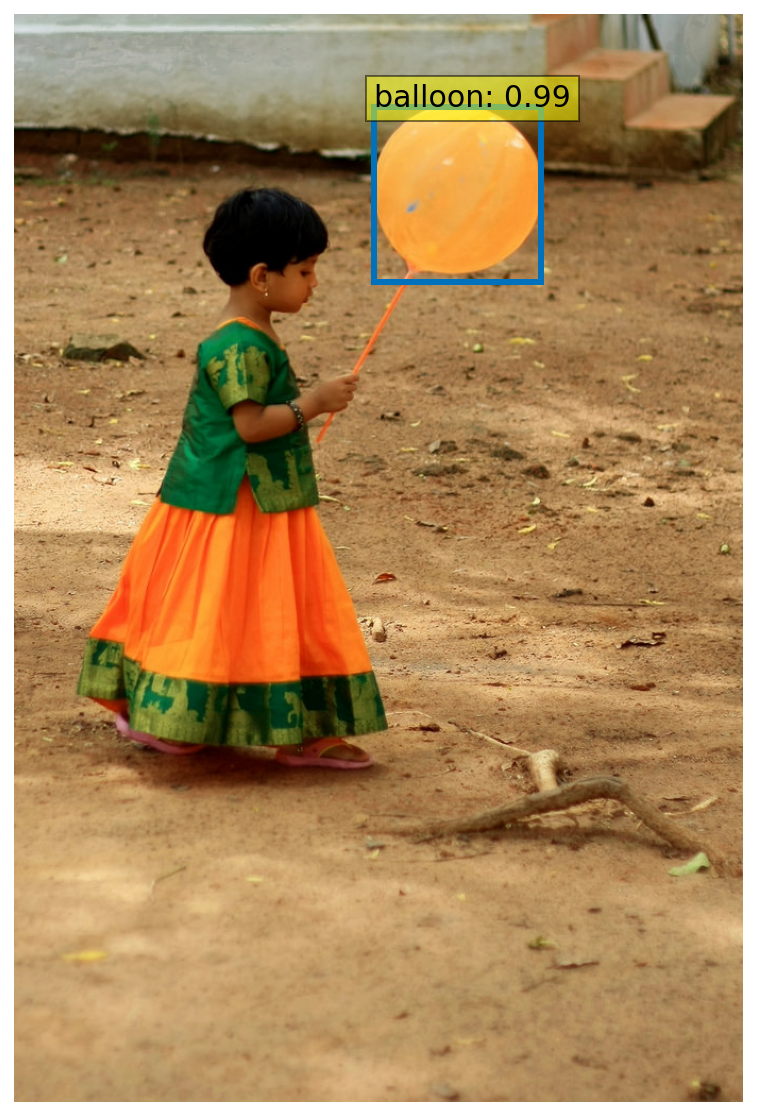

In [21]:
im = Image.open(r"util\Balloon\val2017\3800636873_ace2c2795f_b.jpg")
print("im: ", im.size)

scores, boxes = detect(im, model, transform, 0.9)
plot_results(im, scores, boxes)

im:  (1536, 2048)


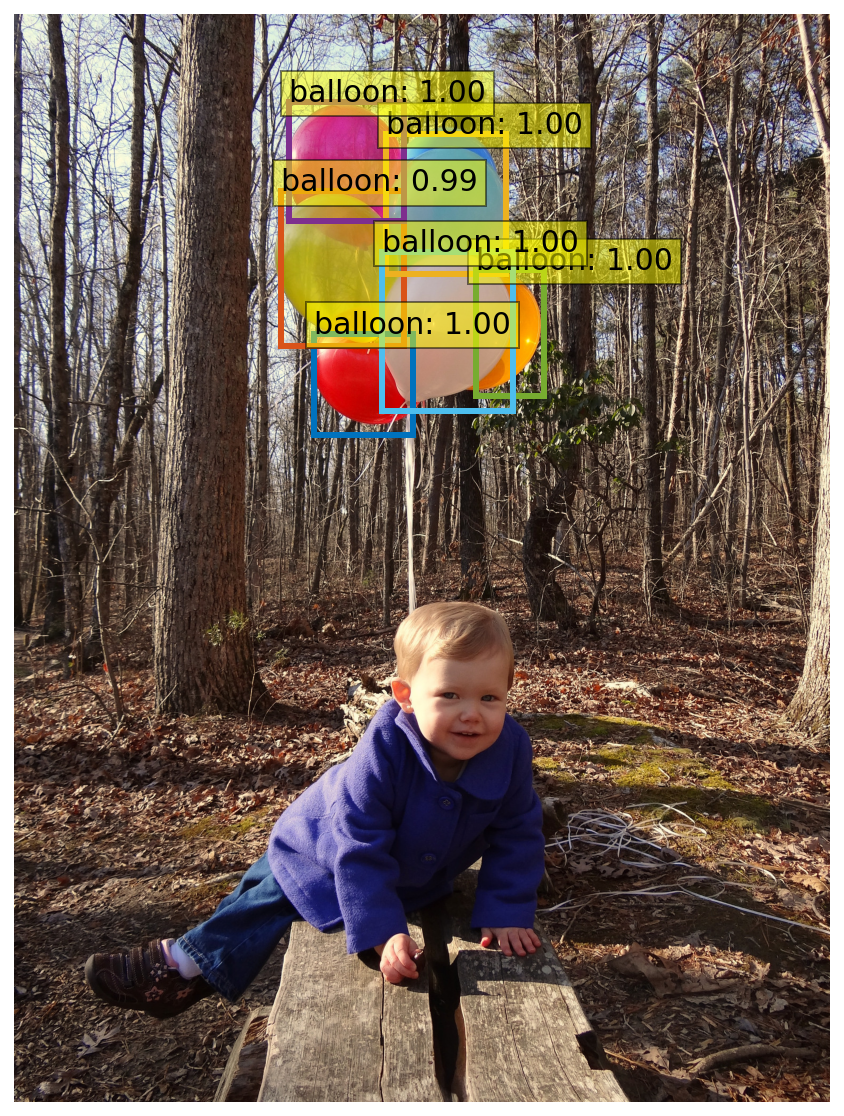

In [22]:
im = Image.open(r"util\Balloon\val2017\16335852991_f55de7958d_k.jpg")
print("im: ", im.size)

scores, boxes = detect(im, model, transform, 0.9)
plot_results(im, scores, boxes)

im:  (2048, 1356)


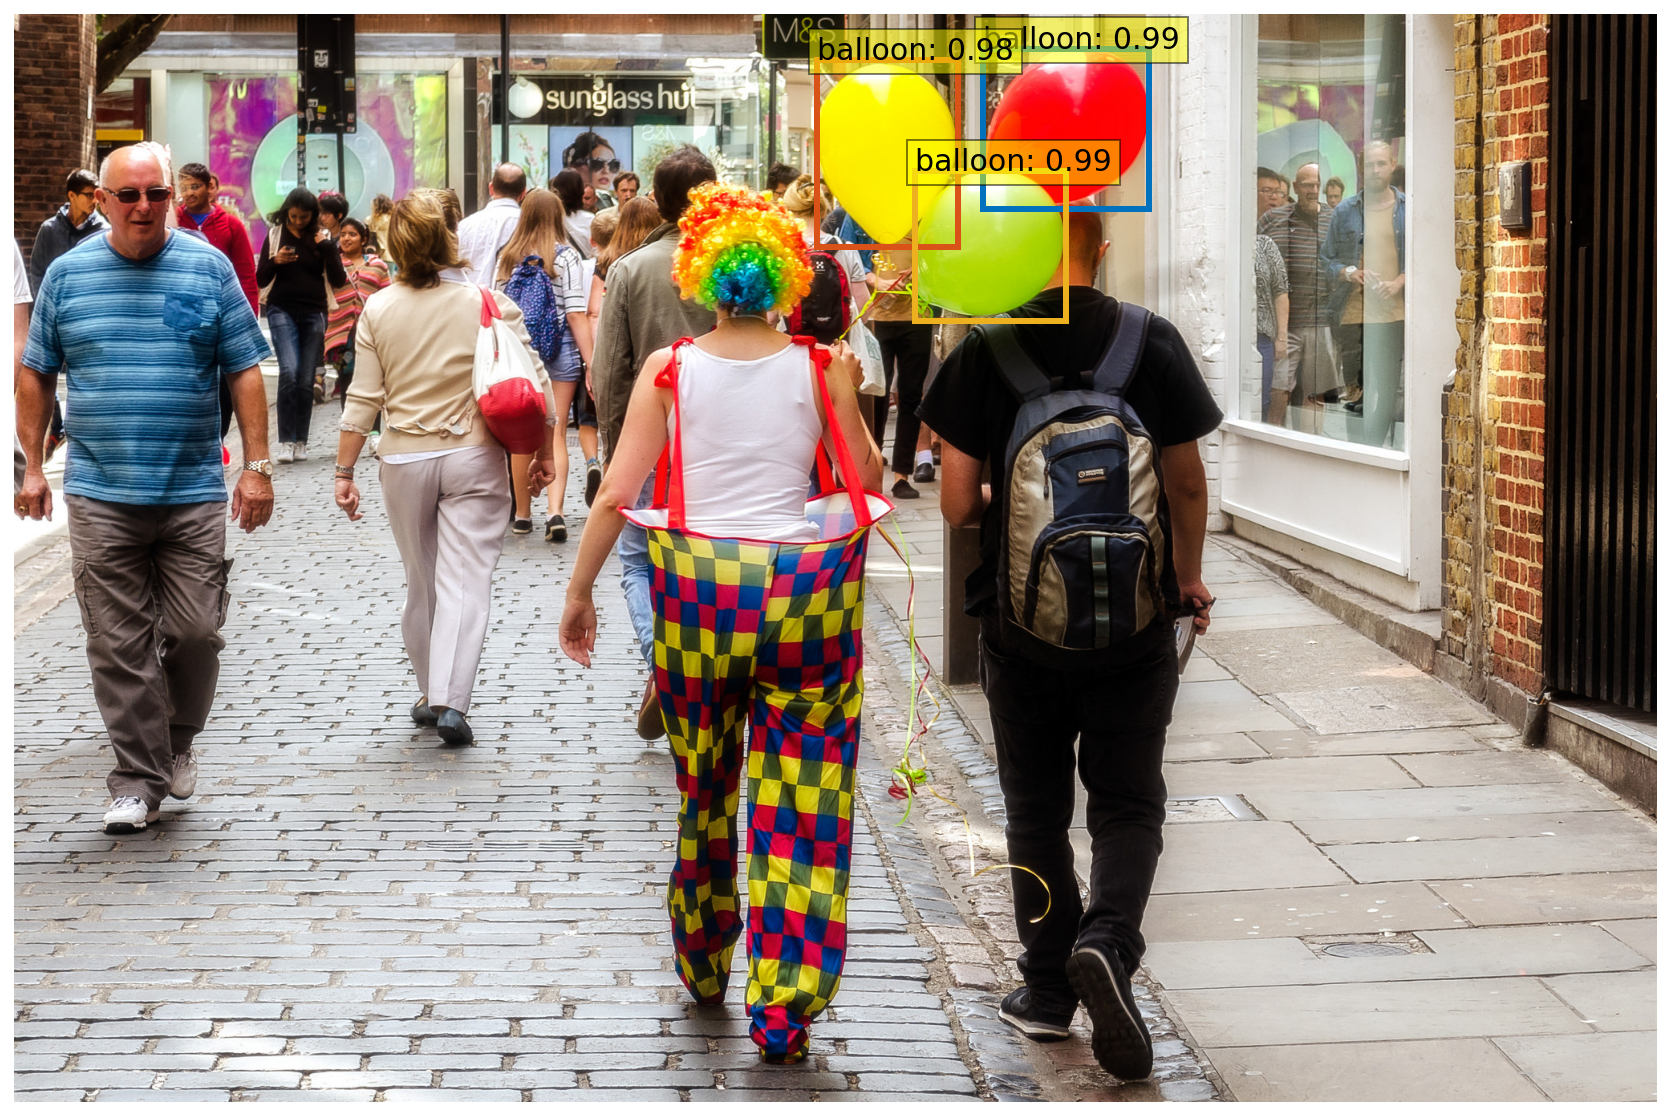

In [23]:
im = Image.open(r"util\Balloon\train2017\15290896925_884ab33fd3_k.jpg")
print("im: ", im.size)

scores, boxes = detect(im, model, transform, 0.9)
plot_results(im, scores, boxes)